In [6]:
# focus 3D

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import supplementary_code as sc

from ipywidgets import interact
from matplotlib import cm
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
from scipy import ndimage as ndi
from scipy import stats

from skimage import (color, data, exposure, feature, filters, io, measure,
                    morphology, restoration, segmentation, transform,
                    util)

%matplotlib inline

In [2]:
data, rescaled, equalized = sc.results_from_part_1()

/Users/dani/anaconda3/envs/imagej/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [3]:
from skimage.external import tifffile
inputfile = 'images/cells_interior_labels.tiff'
relabeled = tifffile.imread(inputfile)

In [4]:
# The microscope reports the following spacing:
original_spacing = np.array([0.2900000, 0.0650000, 0.0650000])
print(f'* Microscope original spacing: {original_spacing}')

# We downsampled each slice 4x to make the data smaller
rescaled_spacing = original_spacing * [1, 4, 4]
print(f'* Microscope after rescaling images: {rescaled_spacing}')

# Normalize the spacing so that pixels are a distance of 1 apart
spacing = rescaled_spacing / rescaled_spacing[2]
print(f'* Microscope normalized spacing: {spacing}')

* Microscope original spacing: [0.29  0.065 0.065]
* Microscope after rescaling images: [0.29 0.26 0.26]
* Microscope normalized spacing: [1.11538462 1.         1.        ]


In [5]:
regionprops = measure.regionprops(relabeled, intensity_image=data)

In [15]:
selected_cell = 3

# skimage.measure.marching_cubes expects ordering (row, col, pln)
volume = (relabeled == regionprops[selected_cell].label).transpose(1, 2, 0)

verts_px, faces_px, _, _ = measure.marching_cubes_lewiner(volume, level=0, spacing=(1.0, 1.0, 1.0))
surface_area_pixels = measure.mesh_surface_area(verts_px, faces_px)

verts, faces, _, _ = measure.marching_cubes_lewiner(volume, level=0, spacing=tuple(spacing))
surface_area_actual = measure.mesh_surface_area(verts, faces)

print("Surface area (total pixels): {:0.2f}".format(surface_area_pixels))
print("Surface area (actual): {:0.2f}".format(surface_area_actual))

Surface area (total pixels): 7296.95
Surface area (actual): 7911.14


# MPL_toolkit:
- def

The volume can be visualized using the mesh vertexes and faces.

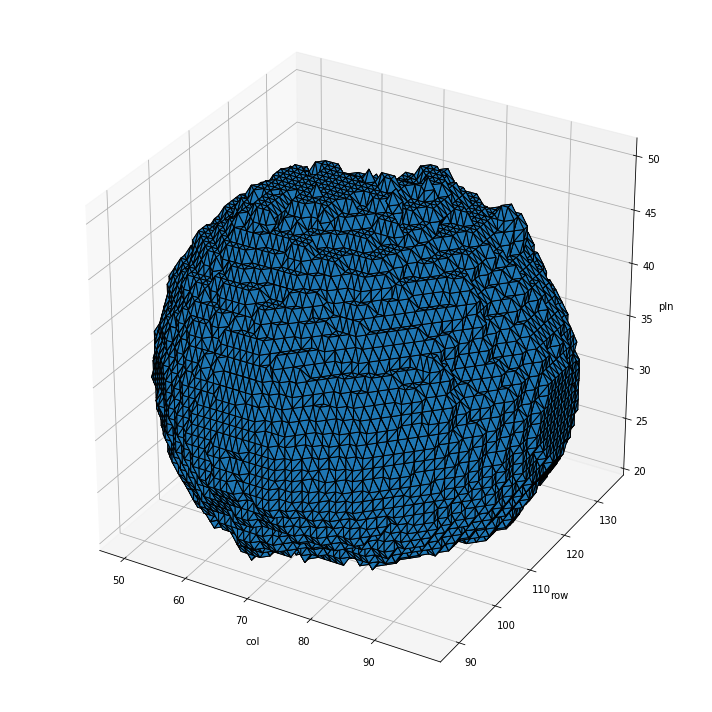

In [13]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

mesh = Poly3DCollection(verts_px[faces_px])
mesh.set_edgecolor("black")
ax.add_collection3d(mesh)

ax.set_xlabel("col")
ax.set_ylabel("row")
ax.set_zlabel("pln")

min_pln, min_row, min_col, max_pln, max_row, max_col = regionprops[selected_cell].bbox

ax.set_xlim(min_row, max_row)
ax.set_ylim(min_col, max_col)
ax.set_zlim(min_pln, max_pln)

plt.tight_layout()
plt.show()

# Mayavi
- def.
- req. jupyter nbextension install --py mayavi --user
- more info. https://docs.enthought.com/mayavi/mayavi/tips.html

In [8]:
from mayavi import mlab
mlab.init_notebook() #variations ('x3d', 800, 800)

Notebook initialized with ipy backend.


In [9]:
s = mlab.test_plot3d()
s

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\x90\x00\x00\x01^\x08\x02\x00\x00\x00$?\xde_\x00\…

In [25]:
volume.shape

(256, 256, 60)

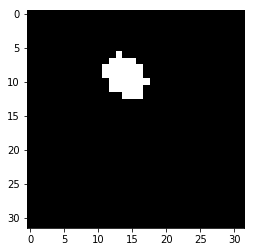

In [38]:
from skimage import img_as_ubyte
v = volume[::8,::8,::3]
v = v.astype(dtype='int')
#v = v.astype(dtype='float')
plt.imshow(v[:,:,10],cmap='gray')

In [58]:
mlab.figure(bgcolor=(0, 0, 0))
s = mlab.pipeline.scalar_field(relabeled)#volume.astype(dtype='int')) #create a mayavi object from our NumPy array by calling


In [59]:
contour = mlab.pipeline.contour(s)
smooth = mlab.pipeline.user_defined(contour, filter='SmoothPolyDataFilter')
smooth.filter.number_of_iterations = 10#400
smooth.filter.relaxation_factor = 0.015
curv = mlab.pipeline.user_defined(smooth, filter='Curvatures')

surf = mlab.pipeline.surface(curv)
module_manager = curv.children[0]
module_manager.scalar_lut_manager.data_range = np.array([-0.6,  0.5])
module_manager.scalar_lut_manager.lut_mode = 'RdBu'
#mlab.show()


In [60]:
surf

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\x90\x00\x00\x01^\x08\x02\x00\x00\x00$?\xde_\x00\…

# ITK widgets in itkwidgets
- def:

In [14]:
#Dani TODO: discuss package 
#https://itkpythonpackage.readthedocs.io/en/latest/Quick_start_guide.html
#https://itk.org/ITKExamples/src/index.html

#https://github.com/InsightSoftwareConsortium/itkwidgets

In [15]:
import itk
from itkwidgets import view

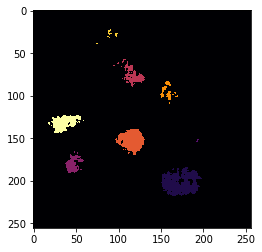

In [16]:
plt.imshow(relabeled[20],cmap='inferno')

In [17]:
print(f"* Data shape: {relabeled.shape}")
print(f"* Data type:  {relabeled.dtype}")
print(f"* Data range: ({relabeled.min()}, {relabeled.max()})")

* Data shape: (60, 256, 256)
* Data type:  int32
* Data range: (0, 9)


In [11]:
#Reformat the numpy array into an itk friendly matrix
image = itk.GetImageFromArray(relabeled.astype(np.int16))
view(image, slicing_planes=True)

#showing full stack

Viewer(gradient_opacity=0.22, rendered_image=<itkImagePython.itkImageSS3; proxy of <Swig Object of type 'itkIm…

In [18]:
image2 = itk.imread('images/cells_interior_labels.tiff') #,itk.ctype('float')) #add this param if needed
view(image2,slicing_planes=True)


Viewer(gradient_opacity=0.22, rendered_image=<itkImagePython.itkImageUC3; proxy of <Swig Object of type 'itkIm…

# Exercise 3. 
Read the file at images/cells_interior_labels.tiff using skimage, then convert the file to visualize with itkwidgets